In [11]:
import pickle
import pandas as pd
import seaborn as sns
import numpy as np
import itertools
import random
from tqdm import tqdm
sns.set()
import matplotlib.pyplot as plt

# Data

In [12]:
wmt_toen = pickle.load(open('../pickles/wmt_toen_bert_score.pkl', 'rb'))
wmt_toen.head(1)

,system,sid,raw_score,score,N,lp,reference,source,output,year,system_full,bert_score
0,online-B,1673,63.0,-0.00167,2,cs-en,Ten statements by Albert Einstein that enriche...,"Desatero výroků Alberta Einsteina, které oboha...",Ten Commandments statements of Albert Einstein...,2016,NaN,0.941577


# Validation

Official BLEURT segment-level results:
https://github.com/google-research/bleurt/blob/master/README.md#overview

In [13]:
wmt_toen[wmt_toen.year == 2019].groupby('lp')[['bert_score', 'score']].corr('kendall')[['bert_score']][1::2].T

lp,fi-en,gu-en,kk-en,lt-en,ru-en
,score,score,score,score,score
bert_score,0.285179,0.270268,0.367223,0.316569,0.256431


# Plots

### Raw correlations

##### Test set

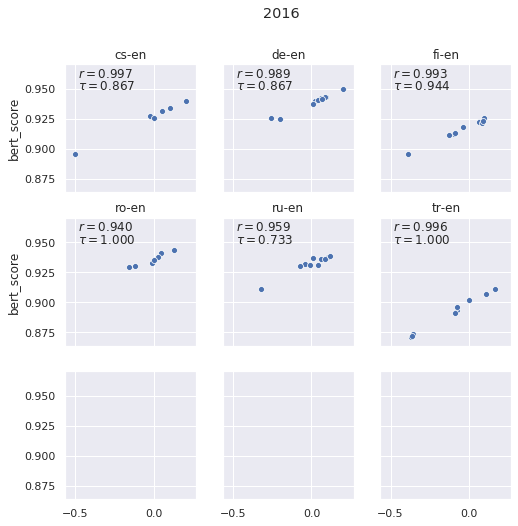

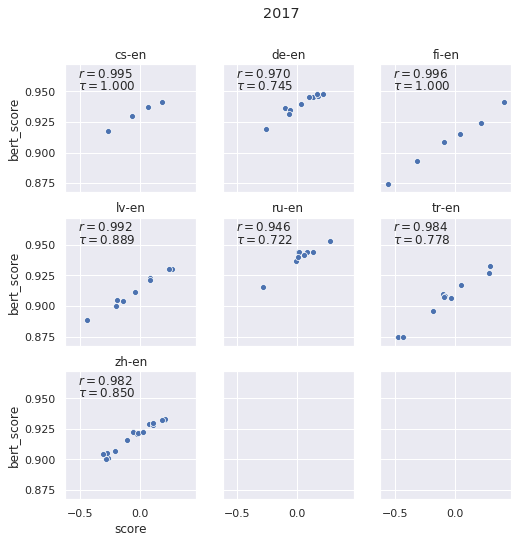

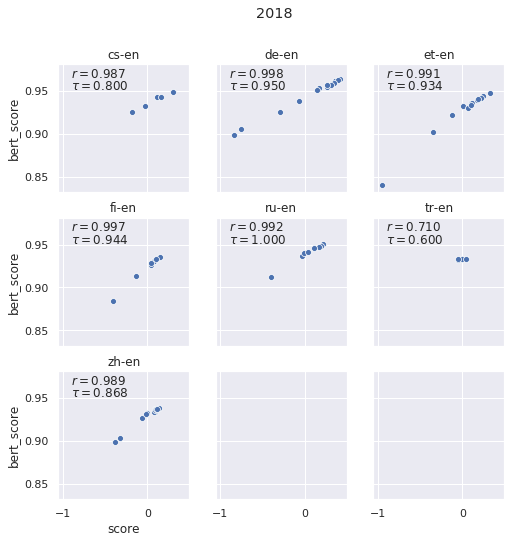

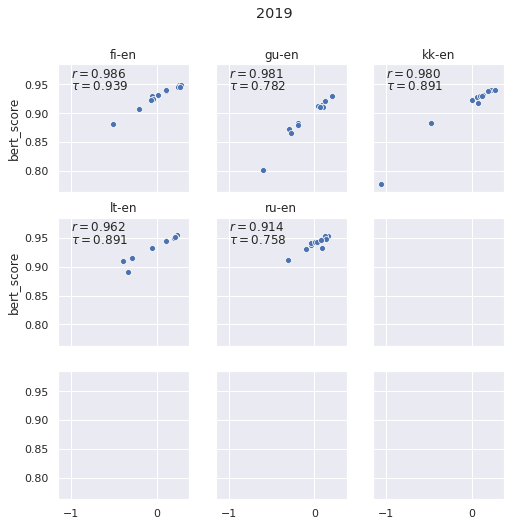

In [14]:
for year, group in wmt_toen.groupby('year'):
    f, axes = plt.subplots(3, 3, figsize=(8,8), sharex=True, sharey=True)
    toen = wmt_toen[wmt_toen.year == year]
    f.suptitle(str(year))

    for coord, (i, group) in zip(itertools.product([0,1,2], [0,1,2]), toen.groupby('lp')):
        system_level = group.groupby('system').mean()
        r = system_level.corr('pearson')['bert_score']['score']
        tau = system_level.corr('kendall')['bert_score']['score']

        ax = axes[coord]
        ax.set_title(i)
        ax.text(0.1, 0.9, '$r=%.3f$' % r, fontsize=12, transform=ax.transAxes)
        ax.text(0.1, 0.8, '$\\tau=%.3f$' % tau, fontsize=12, transform=ax.transAxes)
        sns.scatterplot(data=system_level, x='score', y='bert_score', ax=ax)

# Pairwise judgments (pt. 1)

### Considering statistical significance

In [20]:
import multiprocessing
pool = multiprocessing.Pool(8)

def f(i):
    subset, s1, s2, human_statistic, metric_statistic = i
    
    subset['labels'] = random.sample(subset['system'].tolist(), len(subset))
    ra_scores = subset.groupby('labels').mean()
    
    return (np.abs(ra_scores['score'][s1] - ra_scores['score'][s2]) > np.abs(human_statistic), \
            np.abs(ra_scores['bert_score'][s1] - ra_scores['bert_score'][s2]) > np.abs(metric_statistic))

In [21]:
trials = 1000
randomized_approx = []

for (year, lp), group in wmt_toen.groupby(['year', 'lp']):
    print(year, lp)
    
    systems = list(group.system.unique())
    pairs = list(itertools.combinations(systems, 2))
    
    for s1, s2 in tqdm(pairs, total=len(pairs)):
        if s1 == s2:
            continue
            
        subset = group[(group.system == s1) | (group.system == s2)].copy()
        scores = subset.groupby('system').mean()
        
        if scores['score'][s2] > scores['score'][s1]:
            # switch
            temp = s1
            s1 = s2
            s2 = temp
            
        human_statistic = scores['score'][s1] - scores['score'][s2]
        metric_statistic = scores['bert_score'][s1] - scores['bert_score'][s2]
        
        # pooled randomized approximation
        results = pool.map(f, [(subset, s1, s2, human_statistic, metric_statistic)] * trials)
        human_c, metric_c = sum(i[0] for i in results), sum(i[1] for i in results)
        
        randomized_approx.append((year, lp, s1, s2, human_statistic, metric_statistic, human_c, metric_c))

  0%|          | 0/15 [00:00<?, ?it/s]

2016 cs-en


  0%|          | 0/45 [00:00<?, ?it/s]

2016 de-en


  0%|          | 0/36 [00:00<?, ?it/s]

2016 fi-en


  0%|          | 0/21 [00:00<?, ?it/s]

2016 ro-en


  0%|          | 0/45 [00:00<?, ?it/s]

2016 ru-en


  0%|          | 0/36 [00:00<?, ?it/s]

2016 tr-en


  0%|          | 0/6 [00:00<?, ?it/s]

2017 cs-en


  0%|          | 0/55 [00:00<?, ?it/s]

2017 de-en


  0%|          | 0/15 [00:00<?, ?it/s]

2017 fi-en


  0%|          | 0/36 [00:00<?, ?it/s]

2017 lv-en


  0%|          | 0/36 [00:00<?, ?it/s]

2017 ru-en


  0%|          | 0/45 [00:00<?, ?it/s]

2017 tr-en


  0%|          | 0/120 [00:00<?, ?it/s]

2017 zh-en


  0%|          | 0/10 [00:00<?, ?it/s]

2018 cs-en


  0%|          | 0/120 [00:00<?, ?it/s]

2018 de-en


  0%|          | 0/91 [00:00<?, ?it/s]

2018 et-en


  0%|          | 0/36 [00:00<?, ?it/s]

2018 fi-en


  0%|          | 0/28 [00:00<?, ?it/s]

2018 ru-en


  0%|          | 0/10 [00:00<?, ?it/s]

2018 tr-en


  0%|          | 0/91 [00:00<?, ?it/s]

2018 zh-en


  0%|          | 0/66 [00:00<?, ?it/s]

2019 fi-en


  0%|          | 0/55 [00:00<?, ?it/s]

2019 gu-en


  0%|          | 0/55 [00:00<?, ?it/s]

2019 kk-en


  0%|          | 0/55 [00:00<?, ?it/s]

2019 lt-en


  0%|          | 0/91 [00:00<?, ?it/s]

2019 ru-en


100%|██████████| 91/91 [02:13<00:00,  1.47s/it]


In [26]:
randomized_approx = pd.DataFrame(randomized_approx)
randomized_approx.columns = ['year', 'lp', 's1', 's2', 'human_statistic', 'metric_statistic', 'human_c', 'metric_c']

ValueError: Length mismatch: Expected axis has 12 elements, new values have 8 elements

In [29]:
alpha = 0.05
randomized_approx['human_sig'] = randomized_approx.human_c / trials < alpha
randomized_approx['metric_sig'] = randomized_approx.metric_c / trials < alpha

def f(row, s = 'human'):
    if row['%s_sig' % s]:
        if row['%s_statistic' % s] > 0:
            return 'gain'
        else:
            return 'loss'
    else:
        return 'NS'

randomized_approx['human_decision'] = randomized_approx.apply(lambda x: f(x, s='human'), axis=1)
randomized_approx['metric_decision'] = randomized_approx.apply(lambda x: f(x, s='metric'), axis=1)

randomized_approx[randomized_approx.human_c > 300].head(5)

,year,lp,s1,s2,human_statistic,metric_statistic,human_c,metric_c,human_sig,metric_sig,human_decision,metric_decision
11,2016,cs-en,online-A,PJATK,0.024639,-0.002010,312,32,False,True,NS,loss
21,2016,de-en,jhu-pbmt,online-G,0.010159,0.002728,675,0,False,True,NS,gain
29,2016,de-en,uedin-pbmt,jhu-pbmt,0.022356,0.000877,358,259,False,False,NS,NS
30,2016,de-en,uedin-syntax,uedin-pbmt,0.023633,0.000835,317,285,False,False,NS,NS
31,2016,de-en,KIT,uedin-pbmt,0.020672,0.001372,358,66,False,False,NS,NS


##### Test set

In [34]:
# we have to be careful in saying NS = 0...
ra = randomized_approx

labels = ['loss', 'NS', 'gain']
confusion = []
for i in labels:
    confusion.append([])
    for j in labels:
        count = len(ra[(ra.human_decision == i) & (ra.metric_decision == j)])
        confusion[-1].append(count)
confusion = np.array(confusion)

heatmap = [ [confusion[0,0]+confusion[2,2], confusion[0,1]+confusion[0,2]+confusion[2,0]+confusion[2,1]], [confusion[1,1], confusion[1,0]+confusion[1,2]] ]

Text(30.5, 0.5, 'human')

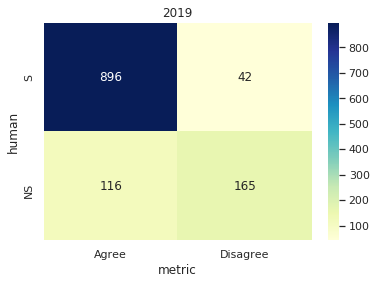

In [35]:
xlabels = ['Agree', 'Disagree' ]
ylabels = ['S', 'NS']
sns.heatmap(heatmap, cmap="YlGnBu", annot=True, fmt="d", xticklabels=xlabels, yticklabels=ylabels)
plt.title('2019')
plt.xlabel('metric')
plt.ylabel('human')

### Save results

In [36]:
pickle.dump(randomized_approx, open('../pickles/randomized_approx_bert_score.pkl', 'wb'))

# Pairwise judgments (pt. 2)

In [37]:
randomized_approx

,year,lp,s1,s2,human_statistic,metric_statistic,human_c,metric_c,human_sig,metric_sig,human_decision,metric_decision
0,2016,cs-en,uedin-nmt,online-B,0.156420,0.007999,0,0,True,True,gain,gain
1,2016,cs-en,online-B,PJATK,0.075290,0.004032,1,0,True,True,gain,gain
2,2016,cs-en,jhu-pbmt,online-B,0.050666,0.002163,48,11,True,True,gain,gain
3,2016,cs-en,online-B,cu-mergedtrees,0.553814,0.035492,0,0,True,True,gain,gain
4,2016,cs-en,online-B,online-A,0.050652,0.006042,60,0,False,True,NS,gain
...,...,...,...,...,...,...,...,...,...,...,...,...
1214,2019,ru-en,online-B.0,NICT.6561,0.424304,0.040909,0,0,True,True,gain,gain
1215,2019,ru-en,Facebook-FAIR.6937,NICT.6561,0.459444,0.042225,0,0,True,True,gain,gain
1216,2019,ru-en,online-B.0,online-A.0,0.091999,0.009216,6,0,True,True,gain,gain
1217,2019,ru-en,Facebook-FAIR.6937,online-A.0,0.127139,0.010532,0,0,True,True,gain,gain


### Pairs where metrics disagree with significant human judgment (about 2-3%)

In [38]:
randomized_approx[(randomized_approx.human_decision != 'NS') & (randomized_approx.human_decision != randomized_approx.metric_decision)]

,year,lp,s1,s2,human_statistic,metric_statistic,human_c,metric_c,human_sig,metric_sig,human_decision,metric_decision
41,2016,de-en,online-F,jhu-syntax,0.057244,-0.001047,20,189,True,False,gain,NS
127,2016,ru-en,PROMT-Rule-based,AFRL-MITLL-Phrase,0.084057,-0.001139,1,112,True,False,gain,NS
134,2016,ru-en,PROMT-Rule-based,AFRL-MITLL-contrast,0.115501,0.000773,0,301,True,False,gain,NS
138,2016,ru-en,online-A,AFRL-MITLL-contrast,0.064525,0.000476,9,581,True,False,gain,NS
144,2016,ru-en,PROMT-Rule-based,online-A,0.050976,0.000296,16,674,True,False,gain,NS
150,2016,ru-en,online-B,uedin-nmt,0.072248,-0.000460,0,524,True,False,gain,NS
157,2016,ru-en,NRC,uedin-nmt,0.049014,-0.000269,26,705,True,False,gain,NS
161,2016,ru-en,AMU-UEDIN,uedin-nmt,0.092034,0.001265,1,92,True,False,gain,NS
231,2017,de-en,online-A,SYSTRAN,0.071037,0.000572,4,442,True,False,gain,NS
234,2017,de-en,KIT,SYSTRAN,0.067561,0.001513,4,53,True,False,gain,NS


### Visualize a pairwise judgment

In [41]:
def visualize_pairwise(year, lp, s1_name, s2_name):
    s1 = wmt_toen[(wmt_toen.year == year) & (wmt_toen.lp == lp) & (wmt_toen.system == s1_name)]
    s2 = wmt_toen[(wmt_toen.year == year) & (wmt_toen.lp == lp) & (wmt_toen.system == s2_name)]

    print(len(s1), len(s2))
    merged = s1.merge(s2, on=['sid'])
    print(len(merged))

    merged['h_diff'] = merged['score_x'] - merged['score_y']
    merged['m_diff'] = merged['bert_score_x'] - merged['bert_score_y']
    
    agree = 0
    for i, row in merged.iterrows():
        if np.sign(row['h_diff']) == np.sign(row['m_diff']):
            agree += 1
    print(agree/len(merged))
    
    sns.jointplot(x='h_diff', y='m_diff', data=merged, kind='scatter')

1016 1016
1016
0.6446850393700787


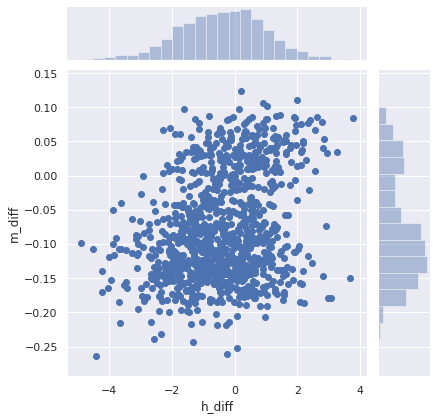

In [42]:
# metric judged incorrectly
visualize_pairwise(year = 2019,
                   lp = 'gu-en',
                   s1_name = 'Ju-Saarland.6525',
                   s2_name = 'online-G.0'
                  )

1692 1699
1447
0.572218382861092


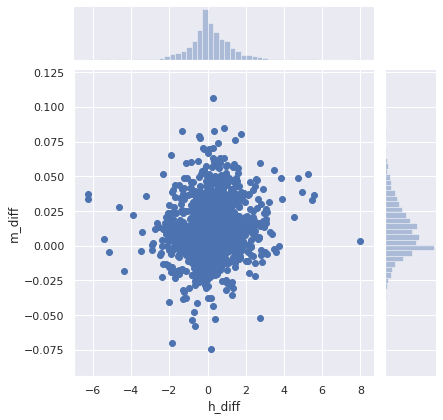

In [43]:
# metric judged correctly
visualize_pairwise(year = 2019,
                   lp = 'ru-en',
                   s1_name = 'Facebook-FAIR.6937',
                   s2_name = 'online-A.0'
                  )